# Part A — Data preparation

## Import all necessary library

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

## load dataset

In [55]:
sentiment = pd.read_csv("data/fear_greed_index.csv")
trades = pd.read_csv("data/historical_data.csv")

print(sentiment.shape)
print(trades.shape)

(2644, 4)
(211224, 16)


## Data cleaning

In [56]:
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment['classification'] = sentiment['classification'].str.strip()
# check for missing or duplicate values
sentiment.isna().sum() 
sentiment.duplicated().sum()

np.int64(0)

## Cleaning trader data

In [59]:
# Preprocess trades data
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')

# Remove rows with missing 'Timestamp IST' or 'Closed PnL'
trades = trades.dropna(subset=['Timestamp IST','Closed PnL'])

## Time Alignment

In [60]:
# Time to date for merging
trades['date'] = trades['Timestamp IST'].dt.date
sentiment['date'] = sentiment['date'].dt.date

data = trades.merge(sentiment[['date','classification']], on='date', how='left')
# Viewing the merged data
data.head(5)


Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-02-12 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-02-12 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-02-12 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-02-12 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-02-12 22:50:00     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
2         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
3         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
4         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   

   Crossed       Fee      Trade ID     Timestamp        date classification  
0     True  0.345404  8.950000e+14  1.730000e+12  2024-02-12          Greed  
1     True  0.005600  4.430000e+14  1.730000e+12  2024-02-12          Greed  
2     True  0.050431  6.600000e+14  1.730000e+12  2024-02-12          Greed  
3     True  0.050043  1.080000e+15  1.730000e+12  2024-02-12          Greed  
4     True  0.003055  1.050000e+15  1.730000e+12  2024-02-12          Greed

## Feature Engineering

In [61]:
# Feature engineering for analysis
data['win'] = np.where(data['Closed PnL'] > 0, 1, 0)
data['abs_size'] = data['Size USD'].abs()
data['is_long'] = np.where(data['Side'].str.lower()=='buy',1,0)


## Daily Trader Metrics

In [62]:
# Daily metrics aggregation
columns_value = {'Closed PnL':'daily_pnl',
    'win':'win_rate',
    'abs_size':'avg_trade_size',
    'Account':'trades_per_day',
    'Execution':'avg_execution_price',
    'is_long':'long_ratio'}
old_column = {'Closed PnL':'sum',
    'win':'mean',
    'abs_size':'mean',
    'Execution Price':'mean',
    'Account':'count',
    'is_long':'mean'} 

daily_metrics = data.groupby(['date','Account','classification']).agg(old_column).rename(columns=columns_value)
daily_metrics = daily_metrics.reset_index()
daily_metrics.head()


date                                     Account classification  \
0  2023-01-05  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891           Fear   
1  2023-05-12  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23        Neutral   
2  2024-01-01  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23          Greed   
3  2024-01-02  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23          Greed   
4  2024-01-03  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4          Greed   

     daily_pnl  win_rate  avg_trade_size  Execution Price  trades_per_day  \
0     0.000000  0.000000      159.000000      1898.133333               3   
1     0.000000  0.000000     5556.203333     11038.300000               9   
2  -129.531460  0.055556    14679.973889     10373.330667              18   
3     0.000000  0.000000      334.696667         0.076126               6   
4  8244.241409  0.934307     3452.370073         2.725657             137   

   long_ratio  
0    1.000000  
1    0.777778  
2    0.555556  
3    1.000000  
4    0.270073

# Part B — Analysis

## Fear vs Greed

  classification     daily_pnl  win_rate
0   Extreme Fear    133.331411  0.173498
1  Extreme Greed  10329.407818  0.335945
2           Fear  11332.647023  0.349909
3          Greed   3191.793365  0.353119
4        Neutral   2017.749783  0.312524


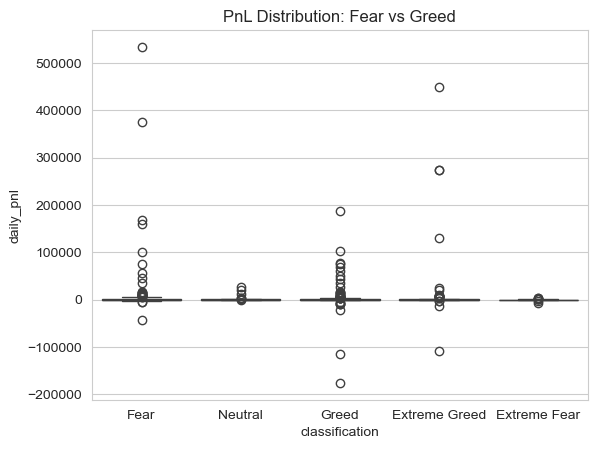

In [65]:
# Compare performance between fear and greed days
perf = daily_metrics.groupby('classification').agg({
    'daily_pnl':'mean',
    'win_rate':'mean'
}).reset_index()

print(perf)
# Visualization of PnL distribution
sns.boxplot(data=daily_metrics, x='classification', y='daily_pnl')
plt.title("PnL Distribution: Fear vs Greed")
plt.show()

In [66]:
# Analyze trading behavior
behavior = daily_metrics.groupby('classification').agg({
    'trades_per_day':'mean',
    'avg_trade_size':'mean',
    'long_ratio':'mean'
}).reset_index()

print(behavior)

  classification  trades_per_day  avg_trade_size  long_ratio
0   Extreme Fear       70.484848     7641.104727    0.656696
1  Extreme Greed       50.187500     7027.976333    0.465272
2           Fear       88.337580     7518.449558    0.539033
3          Greed       59.120419     7029.606816    0.542503
4        Neutral       74.486486     5763.624619    0.449981


# High vs Low Trade Size

In [68]:
# Segment trades by size and analyze performance
threshold = data['abs_size'].median()
data['size_segment'] = np.where(data['abs_size']>threshold,'High Size','Low Size')

seg_perf = data.groupby(['size_segment','classification'])['Closed PnL'].mean().reset_index()
print(seg_perf)

  size_segment classification  Closed PnL
0    High Size   Extreme Fear    2.640554
1    High Size  Extreme Greed  486.467899
2    High Size           Fear  246.380931
3    High Size          Greed  100.489932
4    High Size        Neutral   61.063063
5     Low Size   Extreme Fear    1.221994
6     Low Size  Extreme Greed   22.893881
7     Low Size           Fear    5.841711
8     Low Size          Greed    6.922615
9     Low Size        Neutral    4.691564


# Frequent vs Infrequent Traders

In [69]:
# Segment traders by frequency and analyze performance
trade_counts = data.groupby('Account')['Account'].count()
freq_threshold = trade_counts.median()

data['freq_segment'] = data['Account'].map(lambda x: 'Frequent' if trade_counts[x]>freq_threshold else 'Infrequent')

freq_perf = data.groupby(['freq_segment','classification'])['Closed PnL'].mean().reset_index()
print(freq_perf)

  freq_segment classification  Closed PnL
0     Frequent   Extreme Fear    0.476383
1     Frequent  Extreme Greed  218.259046
2     Frequent           Fear  119.540296
3     Frequent          Greed   51.553183
4     Frequent        Neutral   27.128004
5   Infrequent   Extreme Fear   19.287066
6   Infrequent  Extreme Greed   76.965265
7   Infrequent           Fear  245.916569
8   Infrequent          Greed   77.105217
9   Infrequent        Neutral   24.492946


# Charts

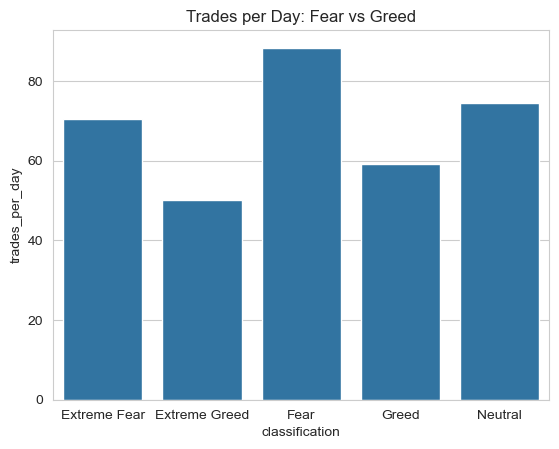

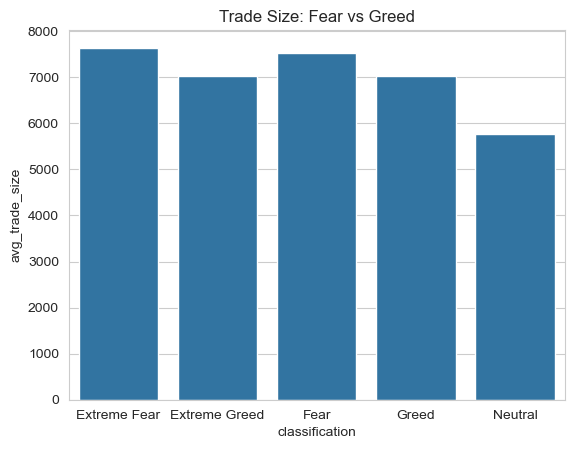

In [70]:
# Visualizations of trading behavior
# Trades per day and average trade size
sns.barplot(data=behavior, x='classification', y='trades_per_day')
plt.title("Trades per Day: Fear vs Greed")
plt.savefig("charts/trades_per_day.png")
plt.show()

sns.barplot(data=behavior, x='classification', y='avg_trade_size')
plt.title("Trade Size: Fear vs Greed")
plt.savefig("charts/trade_size.png")

plt.show()


## PART C — Strategy Ideas

# Ml Model

In [71]:
# Simple predictive model for trade outcome using machine learning classification
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare data for modeling
data['target'] = np.where(data['Closed PnL']>0,1,0)

features = data[['abs_size','is_long']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, data['target'], test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Model Accuracy:", model.score(X_test, y_test))


Model Accuracy: 0.6674660776270117
